Speeding up the transformers

1. Mixed Precision.
2. Parameter Sharing.
3. One cycle policy.
4. d_ff 128 ( hidden layer of feed forward network).
5. Dynamic Padding



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/AI/ERA_course/session15/

In [2]:
! lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          16
On-line CPU(s) list:             0-15
Thread(s) per core:              2
Core(s) per socket:              8
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) W-3223 CPU @ 3.50GHz
Stepping:                        7
CPU MHz:                         1626.806
CPU max MHz:                     4200.0000
CPU min MHz:                     1200.0000
BogoMIPS:                        7000.00
Virtualization:                  VT-x
L1d cache:                       256 KiB
L1i cache:                       256 KiB
L2 cache:                        8 MiB
L3 cache:                        

In [3]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install torchmetrics --quiet
!pip install tensorboard --quiet
!pip install lightning==2.0.1 --quiet
!pip install seaborn

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger,CSVLogger
import torch
import torch.nn as nn
import torchmetrics
import warnings
warnings.filterwarnings("ignore")
import logging
from torch.optim.lr_scheduler import OneCycleLR
import seaborn as sn
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.8 MB/s eta 0:00:00ta 0:00:01


In [4]:
from model import build_transformer
from config import get_config
from train import get_ds
from transformers import DataCollatorWithPadding


warnings.filterwarnings("ignore")

logger = logging.getLogger("Transformer")
logger.setLevel(level=logging.INFO)
fileHandler = logging.FileHandler(filename='prediction.log')
fileHandler.setLevel(level=logging.INFO)
logger.addHandler(fileHandler)

cfg = get_config()
cfg['preload'] = None
cfg['num_epochs'] = 40
cfg['batch_size'] = 16

In [5]:
#### Loading Datasets
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(cfg)

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [6]:
class LitTr(pl.LightningModule):
    def __init__(self,cfg,tokenizer_src,tokenizer_tgt):
        super().__init__()

        vocab_src_len = tokenizer_src.get_vocab_size()
        vocab_tgt_len = tokenizer_tgt.get_vocab_size()
        self.model    = build_transformer(vocab_src_len, vocab_tgt_len, cfg['seq_len'], cfg['seq_len'], d_model=cfg['d_model'])
        self.loss_fn  = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1)
        self.BATCH_SIZE = cfg['batch_size']
        self.num_epochs = cfg['num_epochs']
        self.lr = cfg['lr']
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.seq_len = cfg['seq_len']
        self.expected = []
        self.predicted = []
        self.initial_epoch = 0
        self.save_hyperparameters()
        self.train_loss = []


    def forward(self, x):

        return self.model(x)

    def training_step(self, batch, batch_idx):

        encoder_input = batch['encoder_input']
        decoder_input = batch['decoder_input']
        encoder_mask  = batch['encoder_mask']
        decoder_mask  = batch['decoder_mask']

        # Run the tensors through the encoder, decoder and the projection layer
        encoder_output = self.model.encode(encoder_input, encoder_mask) # (b, seq_len, d_model)
        decoder_output = self.model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
        proj_output = self.model.project(decoder_output) # ( b, seq_len, vocab_size)

        label = batch['label']

        loss = self.loss_fn(proj_output.view(-1, self.tokenizer_tgt.get_vocab_size()), label.view(-1))
        self.train_loss.append(loss)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True,logger=True)
        return loss

    def casual_mask(self, size):
        mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
        return(mask == 0)

    def greedy_decode(self,source, source_mask):

        sos_idx = self.tokenizer_tgt.token_to_id('[SOS]')
        eos_idx = self.tokenizer_tgt.token_to_id('[EOS]')

        encoder_output = self.model.encode(source, source_mask)
        decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source)

        while True:
            if decoder_input.size(1) == self.seq_len:
              break

            decoder_mask = self.casual_mask(decoder_input.size(1)).type_as(source_mask)

            out = self.model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

            prob = self.model.project(out[:,-1])
            _,next_word = torch.max(prob, dim=1)

            decoder_input = torch.cat(
                [decoder_input, torch.empty(1,1).type_as(source).fill_(next_word.item())], dim=1
            )

            if next_word == eos_idx:
              break

        return decoder_input.squeeze(0)

    def on_train_epoch_end(self):

        self.log('loss', torch.stack(self.train_loss).mean(), on_epoch=True, logger=True)
        print(f"Epoch {self.current_epoch} : Loss Mean - {torch.stack(self.train_loss).mean()}")
        self.train_loss.clear()

    def evaluate(self, batch, stage=None):

        encoder_input = batch["encoder_input"]
        encoder_mask  = batch["encoder_mask"]


        model_out = self.greedy_decode(encoder_input, encoder_mask)

        source_text = batch["src_text"][0]
        target_text = batch["tgt_text"][0]


        model_out_text = self.tokenizer_tgt.decode(model_out.detach().cpu().numpy())

        logger.info(f"SOURCE - {source_text}")
        logger.info(f"TARGET - {target_text}")
        logger.info(f"PREDICTED - {model_out_text}")
        logger.info("=============================================================")

        self.expected.append(target_text)
        self.predicted.append(model_out_text)


    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def on_validation_epoch_end(self):
        metric = torchmetrics.CharErrorRate()
        cer = metric(self.predicted, self.expected)
        self.log('validation_cer', cer, prog_bar=True, on_epoch=True, logger=True)


        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(self.predicted, self.expected)
        self.log('validation_wer', wer, prog_bar=True, on_epoch=True, logger=True)

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(self.predicted, self.expected)
        self.log('validation_bleu', bleu, prog_bar=True, on_epoch=True, logger=True)

        self.expected.clear()
        self.predicted.clear()

    def optimizer_zero_grad(self, epoch, batch_idx, optimizer):
        optimizer.zero_grad(set_to_none=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, eps = 1e-9)
        scheduler = OneCycleLR(
                        optimizer,
                        max_lr= 10**-3,
                        pct_start = 1/10,
                        epochs=self.trainer.max_epochs,
                        steps_per_epoch=len(train_dataloader),
                        div_factor=10,
                        three_phase=True,
                        final_div_factor=10,
                        anneal_strategy='linear'
                    )
        return {
             "optimizer": optimizer,
             "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
             }

In [7]:
trainer = pl.Trainer(log_every_n_steps=1,
                     #accumulate_grad_batches=5,
                     limit_val_batches=2,
                     check_val_every_n_epoch=1,
                     max_epochs = cfg['num_epochs'],
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     #precision="bf16", #"16-mixed",
                     logger=[TensorBoardLogger("logs/", name="transformer-bilin"),CSVLogger(save_dir="logs/")],
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
#### Loading the lightning module
model = LitTr(cfg,tokenizer_src,tokenizer_tgt)
#torch.set_float32_matmul_precision('medium')
trainer.fit(model, train_dataloader ,val_dataloader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/transformer-bilin
Missing logger folder: logs/transformer-bilin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Transformer      | 56.3 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.350   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0 : Loss Mean - 5.549231052398682
Epoch 0 : Loss Mean - 5.5492377281188965


Validation: 0it [00:00, ?it/s]

Epoch 1 : Loss Mean - 4.2207136154174805
Epoch 1 : Loss Mean - 4.215906143188477


Validation: 0it [00:00, ?it/s]

Epoch 2 : Loss Mean - 3.705514669418335
Epoch 2 : Loss Mean - 3.7040247917175293


Validation: 0it [00:00, ?it/s]

Epoch 3 : Loss Mean - 3.442697048187256
Epoch 3 : Loss Mean - 3.4568750858306885


Validation: 0it [00:00, ?it/s]

Epoch 4 : Loss Mean - 3.282776355743408
Epoch 4 : Loss Mean - 3.2853481769561768


Validation: 0it [00:00, ?it/s]

Epoch 5 : Loss Mean - 3.151622772216797
Epoch 5 : Loss Mean - 3.159273624420166


Validation: 0it [00:00, ?it/s]

Epoch 6 : Loss Mean - 3.0540356636047363
Epoch 6 : Loss Mean - 3.051820993423462


Validation: 0it [00:00, ?it/s]

Epoch 7 : Loss Mean - 2.9671382904052734
Epoch 7 : Loss Mean - 2.9617059230804443


Validation: 0it [00:00, ?it/s]

Epoch 8 : Loss Mean - 2.8440349102020264
Epoch 8 : Loss Mean - 2.8413522243499756


Validation: 0it [00:00, ?it/s]

Epoch 9 : Loss Mean - 2.669888734817505
Epoch 9 : Loss Mean - 2.666386127471924


Validation: 0it [00:00, ?it/s]

Epoch 10 : Loss Mean - 2.5097439289093018
Epoch 10 : Loss Mean - 2.511845588684082


Validation: 0it [00:00, ?it/s]

Epoch 11 : Loss Mean - 2.3721745014190674
Epoch 11 : Loss Mean - 2.372692108154297


Validation: 0it [00:00, ?it/s]

Epoch 12 : Loss Mean - 2.249357223510742
Epoch 12 : Loss Mean - 2.251004695892334


Validation: 0it [00:00, ?it/s]

Epoch 13 : Loss Mean - 2.142806053161621
Epoch 13 : Loss Mean - 2.1429312229156494


Validation: 0it [00:00, ?it/s]

Epoch 14 : Loss Mean - 2.04990553855896
Epoch 14 : Loss Mean - 2.0495216846466064


Validation: 0it [00:00, ?it/s]

Epoch 15 : Loss Mean - 1.9704395532608032
Epoch 15 : Loss Mean - 1.9703822135925293


Validation: 0it [00:00, ?it/s]

Epoch 16 : Loss Mean - 1.9208616018295288
Epoch 16 : Loss Mean - 1.9203752279281616


Validation: 0it [00:00, ?it/s]

Epoch 17 : Loss Mean - 1.9007327556610107
Epoch 17 : Loss Mean - 1.9024547338485718


Validation: 0it [00:00, ?it/s]

Epoch 18 : Loss Mean - 1.8855037689208984
Epoch 18 : Loss Mean - 1.8874841928482056


Validation: 0it [00:00, ?it/s]

Epoch 19 : Loss Mean - 1.870411992073059
Epoch 19 : Loss Mean - 1.8753553628921509


Validation: 0it [00:00, ?it/s]

Epoch 20 : Loss Mean - 1.8607381582260132
Epoch 20 : Loss Mean - 1.8598287105560303


Validation: 0it [00:00, ?it/s]

Epoch 21 : Loss Mean - 1.849504828453064
Epoch 21 : Loss Mean - 1.847952127456665


Validation: 0it [00:00, ?it/s]

Epoch 22 : Loss Mean - 1.8369539976119995
Epoch 22 : Loss Mean - 1.840207576751709


Validation: 0it [00:00, ?it/s]

Epoch 23 : Loss Mean - 1.8274880647659302
Epoch 23 : Loss Mean - 1.8298563957214355


Validation: 0it [00:00, ?it/s]

Epoch 24 : Loss Mean - 1.8199825286865234
Epoch 24 : Loss Mean - 1.8188104629516602


Validation: 0it [00:00, ?it/s]

Epoch 25 : Loss Mean - 1.8099604845046997
Epoch 25 : Loss Mean - 1.8114389181137085


Validation: 0it [00:00, ?it/s]

Epoch 26 : Loss Mean - 1.8006149530410767
Epoch 26 : Loss Mean - 1.8045436143875122


Validation: 0it [00:00, ?it/s]

Epoch 27 : Loss Mean - 1.794830560684204
Epoch 27 : Loss Mean - 1.7946239709854126


Validation: 0it [00:00, ?it/s]

Epoch 28 : Loss Mean - 1.7862435579299927
Epoch 28 : Loss Mean - 1.7889318466186523


Validation: 0it [00:00, ?it/s]

Epoch 29 : Loss Mean - 1.779228925704956
Epoch 29 : Loss Mean - 1.7813061475753784


Validation: 0it [00:00, ?it/s]

Epoch 30 : Loss Mean - 1.773807168006897
Epoch 30 : Loss Mean - 1.774092674255371


Validation: 0it [00:00, ?it/s]

Epoch 31 : Loss Mean - 1.7668216228485107
Epoch 31 : Loss Mean - 1.7675812244415283


Validation: 0it [00:00, ?it/s]

Epoch 32 : Loss Mean - 1.7601654529571533
Epoch 32 : Loss Mean - 1.762080192565918


Validation: 0it [00:00, ?it/s]

Epoch 33 : Loss Mean - 1.7542587518692017
Epoch 33 : Loss Mean - 1.756295919418335


Validation: 0it [00:00, ?it/s]

Epoch 34 : Loss Mean - 1.7495344877243042
Epoch 34 : Loss Mean - 1.7492518424987793


Validation: 0it [00:00, ?it/s]

Epoch 35 : Loss Mean - 1.743970274925232
Epoch 35 : Loss Mean - 1.7440154552459717


Validation: 0it [00:00, ?it/s]

Epoch 36 : Loss Mean - 1.7387553453445435
Epoch 36 : Loss Mean - 1.7387943267822266


Validation: 0it [00:00, ?it/s]

Epoch 37 : Loss Mean - 1.7343342304229736
Epoch 37 : Loss Mean - 1.7334656715393066


Validation: 0it [00:00, ?it/s]

Epoch 38 : Loss Mean - 1.7296792268753052
Epoch 38 : Loss Mean - 1.728698492050171


Validation: 0it [00:00, ?it/s]

Epoch 39 : Loss Mean - 1.7228209972381592
Epoch 39 : Loss Mean - 1.7253867387771606


`Trainer.fit` stopped: `max_epochs=40` reached.


,validation_cer,validation_wer,validation_bleu,train_loss,loss
epoch,,,,,
0,0.569231,0.857143,0.0,NaN,NaN
0,NaN,NaN,NaN,5.548597,5.549238
1,0.666667,0.941176,0.0,NaN,NaN
1,NaN,NaN,NaN,4.216208,4.215906
2,0.442623,0.789474,0.0,NaN,NaN


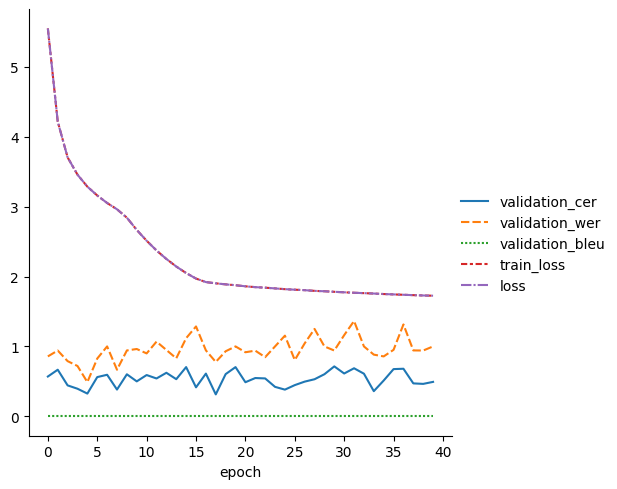

In [11]:
metrics = pd.read_csv("logs/lightning_logs/version_0/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [10]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/